In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout,Cropping2D
from keras.optimizers import Adam, Adamax, Nadam, Adadelta, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.io_utils import HDF5Matrix
import h5py

from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import shapely.wkt
import shapely.affinity
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import smooth_tiled_predictions


/home/yokoyang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_mask(image_id):
    filename = os.path.join(
        Dir, 'land', '{}.tif'.format(image_id))
    msk = tiff.imread(filename)
    msk = msk.astype(np.float32) / 255
    msk_img = np.zeros([size, size], dtype=np.uint8)
    msk_img[:, :] = msk[:, :, 1]
    msk_img ^= 1
    return msk_img


def get_image(image_id):
    filename = os.path.join(
        Dir, 'satellite', '{}.tif'.format(image_id))
    img = tiff.imread(filename)
    img = img.astype(np.float32) / 255
    img_RGB = cv2.resize(img, (Scale_Size, Scale_Size))

    return img_RGB


def reflect_img(img):
    reflect = cv2.copyMakeBorder(img, int(edge_size), int(edge_size), int(edge_size), int(edge_size),
                                 cv2.BORDER_REFLECT)
    return reflect


def get_patch(img_id, pos=1):
    img_ = []
    msk_ = []
    img = get_image(img_id)
    img = reflect_img(img)
    mask = get_mask(img_id)
    for i in range(N_split):
        for j in range(N_split):
            y = mask[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)]
            if ((pos == 1) and (np.sum(y) > 0)) or (pos == 0):
                x_start = int(Patch_size * i)
                x_end = int(Patch_size * (i + 1) + edge_size * 2)

                y_start = int(Patch_size * j)
                y_end = int(Patch_size * (j + 1) + edge_size * 2)
                x = img[x_start:x_end, y_start:y_end, :]
                img_.append(x)

    for i in range(N_split):
        for j in range(N_split):
            y = mask[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)]
            if ((pos == 1) and (np.sum(y) > 0)) or (pos == 0):
                msk_.append(y[:, :, None])

    return img_, msk_


def get_all_patches(pos=1):
    img_all = []
    msk_all = []
    count = 0
    for img_id in Image_ID:
        img_, msk_ = get_patch(img_id, pos=pos)
        if len(msk_) > 0:
            count = count + 1
            if count == 1:
                img_all = img_
                msk_all = msk_
            else:
                img_all = np.concatenate((img_all, img_), axis=0)
                msk_all = np.concatenate((msk_all, msk_), axis=0)

    # if pos == 1:
    #     np.save(Dir + '/output/data_pos_%d_%d_class%d' % (crop_size, N_split, Class_Type), img_all)
    #
    # else:
    #     np.save(Dir + '/output/data_%d_%d_class%d' % (crop_size, N_split, Class_Type), img_all)

    return img_all, msk_all[:, :, :, 0]


def get_normalized_patches():
    img_all, msk_all = get_all_patches()
    #     data = np.load(Dir + '/output/data_pos_%d_%d_class%d.npy' % (Patch_size, N_split, Class_Type))
    img = img_all
    msk = msk_all
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / std
    print(mean, std)
    print(np.mean(img), np.std(img))
    return img, msk


In [3]:
def get_unet_6():
    #     Patch_size = 224
    inputs = Input((crop_size, crop_size, 3))

    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    #     drop5 = Dropout(0.5)(conv4)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool5)
    conv6 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    #     drop5 = Dropout(0.5)(conv5)

    up7 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv5, up7], axis=3)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv4, up8], axis=3)
    conv8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv3, up9], axis=3)
    conv9 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    up10 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv9))
    merge10 = concatenate([conv2, up10], axis=3)
    conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge10)
    conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)

    up11 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv10))
    merge11 = concatenate([conv1, up11], axis=3)
    conv11 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge11)
    conv11 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv11)

    #     conv11 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv12 = Conv2D(1, 1, activation='sigmoid')(conv11)
    cropping_2d = Cropping2D(cropping=((edge_size, edge_size), (edge_size, edge_size)),
                             input_shape=(int(crop_size), int(crop_size), 3))(conv12)

    model = Model(inputs=inputs, outputs=cropping_2d)
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    #     model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])
    #     model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])  
    #     model.compile(optimizer=Adamax(), loss='binary_crossentropy', metrics=['accuracy'])
    #     model.compile(optimizer=Adadelta(), loss='binary_crossentropy', metrics=['accuracy'])     

    return model


In [4]:
Dir = '/home/yokoyang/Downloads/kaggle-data/EU'

train_img = pd.read_csv(Dir + '/data_imageID.csv')

Image_ID = sorted(train_img.ImageId.unique())
print(Image_ID)

N_split = 4

Patch_size = 256
crop_size = 288
edge_size = int((crop_size - Patch_size) / 2)
Class_Type = 1
# 1200 = 300 * 4
size = 1024
Scale_Size = Patch_size * N_split
get_size = 100


['Amsterdam_0_0', 'Amsterdam_0_1', 'Amsterdam_0_2', 'Amsterdam_0_3', 'Amsterdam_0_4', 'Amsterdam_0_5', 'Amsterdam_0_6', 'Amsterdam_1_0', 'Amsterdam_1_1', 'Amsterdam_1_2', 'Amsterdam_1_3', 'Amsterdam_1_4', 'Amsterdam_1_5', 'Amsterdam_1_6', 'Amsterdam_2_0', 'Amsterdam_2_1', 'Amsterdam_2_2', 'Amsterdam_2_3', 'Amsterdam_2_4', 'Amsterdam_2_5', 'Amsterdam_2_6', 'Amsterdam_3_0', 'Amsterdam_3_1', 'Amsterdam_3_2', 'Amsterdam_3_3', 'Amsterdam_3_4', 'Amsterdam_3_5', 'Amsterdam_3_6', 'Amsterdam_4_0', 'Amsterdam_4_1', 'Amsterdam_4_2', 'Amsterdam_4_3', 'Amsterdam_4_4', 'Amsterdam_4_5', 'Amsterdam_4_6', 'Amsterdam_5_0', 'Amsterdam_5_1', 'Amsterdam_5_2', 'Amsterdam_5_3', 'Amsterdam_5_4', 'Amsterdam_5_5', 'Amsterdam_5_6', 'Berlin_0_0', 'Berlin_0_1', 'Berlin_0_2', 'Berlin_0_3', 'Berlin_0_4', 'Berlin_0_5', 'Berlin_0_6', 'Berlin_1_0', 'Berlin_1_1', 'Berlin_1_2', 'Berlin_1_3', 'Berlin_1_4', 'Berlin_1_5', 'Berlin_1_6', 'Berlin_2_0', 'Berlin_2_1', 'Berlin_2_2', 'Berlin_2_3', 'Berlin_2_4', 'Berlin_2_5', 'Berl

In [5]:
# In predicting testing dataset, need to use the same mean and std in preprocessing training data
def post_normalize_image(img, mean=0.48894683, std=0.2100344):
    img = (img - mean) / std
    return img


In [6]:
all_Image_ID = sorted(train_img.ImageId.unique())
all_len = len(all_Image_ID)
loop_time = all_len // get_size
last_weight = ''
loop_i = 0
for i in range(loop_time):
    Image_ID = random.sample(all_Image_ID, get_size)
    all_Image_ID = [Image_ID2 for Image_ID2 in all_Image_ID if Image_ID2 not in Image_ID]
    img, msk = get_normalized_patches()
    x_trn, x_val, y_trn, y_val = train_test_split(img, msk, test_size=0.2, random_state=42)
    y_trn = y_trn[:, :, :, None]
    y_val = y_val[:, :, :, None]

    model = get_unet_6()
    if i != 0:
        print("loaded")
        model.load_weights(last_weight)

    check_point_file_name = str(loop_i) + '_unet6_c1.hdf5'
    model_checkpoint = ModelCheckpoint(check_point_file_name, save_best_only=True)
    model.fit(x_trn, y_trn, batch_size=16, epochs=20, verbose=1, shuffle=True, callbacks=[model_checkpoint],
              validation_data=(x_val, y_val))
    last_weight = check_point_file_name
    loop_i += 1
    del x_trn, x_val, y_trn, y_val, model

img_last = all_len - loop_time * get_size
if img_last > 0:
    Image_ID = random.sample(all_Image_ID, img_last)
    print(len(Image_ID))

    all_Image_ID = [Image_ID2 for Image_ID2 in all_Image_ID if Image_ID2 not in Image_ID]

    img, msk = get_normalized_patches()
    x_trn, x_val, y_trn, y_val = train_test_split(img, msk, test_size=0.2, random_state=42)
    y_trn = y_trn[:, :, :, None]
    y_val = y_val[:, :, :, None]

    model = get_unet_6()
    if loop_i != 0:
        print("loaded")
        model.load_weights(last_weight)
    # model.load_weights("1unet5_c1.hdf5")
    check_point_file_name = str(loop_i) + '_unet6_c1.hdf5'
    model_checkpoint = ModelCheckpoint(check_point_file_name, save_best_only=True)
    model.fit(x_trn, y_trn, batch_size=16, epochs=20, verbose=1, shuffle=True, callbacks=[model_checkpoint],
              validation_data=(x_val, y_val))
    last_weight = check_point_file_name


In [7]:
last_weight 

'0_unet6_c1.hdf5'

In [8]:
if img_last > 0:
    Image_ID = random.sample(all_Image_ID, img_last)
    print(len(Image_ID))

    all_Image_ID = [Image_ID2 for Image_ID2 in all_Image_ID if Image_ID2 not in Image_ID]

    img, msk = get_normalized_patches()
    x_trn, x_val, y_trn, y_val = train_test_split(img, msk, test_size=0.2, random_state=42)
    y_trn = y_trn[:, :, :, None]
    y_val = y_val[:, :, :, None]

    model = get_unet_6()
    model.load_weights(last_weight)
    # model.load_weights("1unet5_c1.hdf5")
    check_point_file_name = str(loop_i) + '_unet6_c1.hdf5'
    model_checkpoint = ModelCheckpoint(check_point_file_name, save_best_only=True)
    model.fit(x_trn, y_trn, batch_size=16, epochs=20, verbose=1, shuffle=True, callbacks=[model_checkpoint],
              validation_data=(x_val, y_val))
    last_weight = check_point_file_name


26


0.4909128 0.2092985
4.2130958e-07 0.99999815


Train on 266 samples, validate on 67 samples
Epoch 1/20


 16/266 [>.............................] - ETA: 1:30 - loss: 0.2079 - acc: 0.9260

 32/266 [==>...........................] - ETA: 49s - loss: 0.2942 - acc: 0.8807 

 48/266 [====>.........................] - ETA: 35s - loss: 0.2658 - acc: 0.8934

 64/266 [======>.......................] - ETA: 27s - loss: 0.2647 - acc: 0.8953

 80/266 [========>.....................] - ETA: 22s - loss: 0.2736 - acc: 0.8928

 96/266 [=========>....................] - ETA: 19s - loss: 0.2679 - acc: 0.8941

112/266 [===========>..................] - ETA: 16s - loss: 0.2571 - acc: 0.8988

128/266 [=============>................] - ETA: 13s - loss: 0.2578 - acc: 0.8981

144/266 [===============>..............] - ETA: 11s - loss: 0.2581 - acc: 0.8982

160/266 [=================>............] - ETA: 9s - loss: 0.2555 - acc: 0.8997 

176/266 [==================>...........] - ETA: 8s - loss: 0.2562 - acc: 0.8993

192/266 [====================>.........] - ETA: 6s - loss: 0.2573 - acc: 0.8988

208/266 [======================>.......] - ETA: 5s - loss: 0.2542 - acc: 0.8999

224/266 [========================>.....] - ETA: 3s - loss: 0.2512 - acc: 0.9011

240/266 [==========================>...] - ETA: 2s - loss: 0.2476 - acc: 0.9029

256/266 [===========================>..] - ETA: 0s - loss: 0.2442 - acc: 0.9044

266/266 [==============================] - 27s 101ms/step - loss: 0.2493 - acc: 0.9035 - val_loss: 0.2508 - val_acc: 0.8996


Epoch 2/20


 16/266 [>.............................] - ETA: 15s - loss: 0.2383 - acc: 0.9089

 32/266 [==>...........................] - ETA: 14s - loss: 0.2695 - acc: 0.8908

 48/266 [====>.........................] - ETA: 13s - loss: 0.2567 - acc: 0.8959

 64/266 [======>.......................] - ETA: 12s - loss: 0.2527 - acc: 0.8986

 80/266 [========>.....................] - ETA: 11s - loss: 0.2489 - acc: 0.8999

 96/266 [=========>....................] - ETA: 10s - loss: 0.2438 - acc: 0.9033

112/266 [===========>..................] - ETA: 9s - loss: 0.2417 - acc: 0.9049 

128/266 [=============>................] - ETA: 8s - loss: 0.2378 - acc: 0.9065

144/266 [===============>..............] - ETA: 7s - loss: 0.2410 - acc: 0.9056

160/266 [=================>............] - ETA: 6s - loss: 0.2429 - acc: 0.9047

176/266 [==================>...........] - ETA: 5s - loss: 0.2386 - acc: 0.9065

192/266 [====================>.........] - ETA: 4s - loss: 0.2363 - acc: 0.9078

208/266 [======================>.......] - ETA: 3s - loss: 0.2358 - acc: 0.9080

224/266 [========================>.....] - ETA: 2s - loss: 0.2384 - acc: 0.9067

240/266 [==========================>...] - ETA: 1s - loss: 0.2373 - acc: 0.9072

256/266 [===========================>..] - ETA: 0s - loss: 0.2329 - acc: 0.9090

266/266 [==============================] - 18s 69ms/step - loss: 0.2321 - acc: 0.9094 - val_loss: 0.2447 - val_acc: 0.9026


Epoch 3/20


 16/266 [>.............................] - ETA: 16s - loss: 0.1924 - acc: 0.9269

 32/266 [==>...........................] - ETA: 15s - loss: 0.2105 - acc: 0.9194

 48/266 [====>.........................] - ETA: 14s - loss: 0.2221 - acc: 0.9141

 64/266 [======>.......................] - ETA: 12s - loss: 0.2287 - acc: 0.9116

 80/266 [========>.....................] - ETA: 11s - loss: 0.2232 - acc: 0.9131

 96/266 [=========>....................] - ETA: 10s - loss: 0.2160 - acc: 0.9159

112/266 [===========>..................] - ETA: 9s - loss: 0.2179 - acc: 0.9149 

128/266 [=============>................] - ETA: 8s - loss: 0.2194 - acc: 0.9137

144/266 [===============>..............] - ETA: 7s - loss: 0.2209 - acc: 0.9137

160/266 [=================>............] - ETA: 6s - loss: 0.2141 - acc: 0.9163

176/266 [==================>...........] - ETA: 5s - loss: 0.2113 - acc: 0.9178

192/266 [====================>.........] - ETA: 4s - loss: 0.2159 - acc: 0.9158

208/266 [======================>.......] - ETA: 3s - loss: 0.2198 - acc: 0.9142

224/266 [========================>.....] - ETA: 2s - loss: 0.2167 - acc: 0.9152

240/266 [==========================>...] - ETA: 1s - loss: 0.2158 - acc: 0.9156

256/266 [===========================>..] - ETA: 0s - loss: 0.2138 - acc: 0.9163

266/266 [==============================] - 18s 69ms/step - loss: 0.2148 - acc: 0.9162 - val_loss: 0.2370 - val_acc: 0.9060


Epoch 4/20


 16/266 [>.............................] - ETA: 16s - loss: 0.1773 - acc: 0.9355

 32/266 [==>...........................] - ETA: 15s - loss: 0.2061 - acc: 0.9211

 48/266 [====>.........................] - ETA: 14s - loss: 0.2152 - acc: 0.9174

 64/266 [======>.......................] - ETA: 12s - loss: 0.2381 - acc: 0.9059

 80/266 [========>.....................] - ETA: 11s - loss: 0.2371 - acc: 0.9079

 96/266 [=========>....................] - ETA: 10s - loss: 0.2277 - acc: 0.9118

112/266 [===========>..................] - ETA: 9s - loss: 0.2224 - acc: 0.9141 

128/266 [=============>................] - ETA: 8s - loss: 0.2173 - acc: 0.9162

144/266 [===============>..............] - ETA: 7s - loss: 0.2148 - acc: 0.9173

160/266 [=================>............] - ETA: 6s - loss: 0.2130 - acc: 0.9176

176/266 [==================>...........] - ETA: 5s - loss: 0.2126 - acc: 0.9176

192/266 [====================>.........] - ETA: 4s - loss: 0.2082 - acc: 0.9194

208/266 [======================>.......] - ETA: 3s - loss: 0.2130 - acc: 0.9177

224/266 [========================>.....] - ETA: 2s - loss: 0.2144 - acc: 0.9171

240/266 [==========================>...] - ETA: 1s - loss: 0.2125 - acc: 0.9179

256/266 [===========================>..] - ETA: 0s - loss: 0.2114 - acc: 0.9184

266/266 [==============================] - 18s 69ms/step - loss: 0.2098 - acc: 0.9189 - val_loss: 0.2406 - val_acc: 0.9050


Epoch 5/20


 16/266 [>.............................] - ETA: 16s - loss: 0.1767 - acc: 0.9331

 32/266 [==>...........................] - ETA: 14s - loss: 0.2294 - acc: 0.9120

 48/266 [====>.........................] - ETA: 13s - loss: 0.2429 - acc: 0.9030

 64/266 [======>.......................] - ETA: 12s - loss: 0.2374 - acc: 0.9052

 80/266 [========>.....................] - ETA: 11s - loss: 0.2288 - acc: 0.9092

 96/266 [=========>....................] - ETA: 10s - loss: 0.2170 - acc: 0.9144

112/266 [===========>..................] - ETA: 9s - loss: 0.2209 - acc: 0.9133 

128/266 [=============>................] - ETA: 8s - loss: 0.2201 - acc: 0.9144

144/266 [===============>..............] - ETA: 7s - loss: 0.2171 - acc: 0.9157

160/266 [=================>............] - ETA: 6s - loss: 0.2145 - acc: 0.9165

176/266 [==================>...........] - ETA: 5s - loss: 0.2177 - acc: 0.9151

192/266 [====================>.........] - ETA: 4s - loss: 0.2143 - acc: 0.9167

208/266 [======================>.......] - ETA: 3s - loss: 0.2142 - acc: 0.9167

224/266 [========================>.....] - ETA: 2s - loss: 0.2156 - acc: 0.9162

240/266 [==========================>...] - ETA: 1s - loss: 0.2140 - acc: 0.9169

256/266 [===========================>..] - ETA: 0s - loss: 0.2097 - acc: 0.9189

266/266 [==============================] - 18s 69ms/step - loss: 0.2081 - acc: 0.9196 - val_loss: 0.2431 - val_acc: 0.9039


Epoch 6/20


 16/266 [>.............................] - ETA: 16s - loss: 0.2338 - acc: 0.9076

 32/266 [==>...........................] - ETA: 15s - loss: 0.2215 - acc: 0.9142

 48/266 [====>.........................] - ETA: 14s - loss: 0.2125 - acc: 0.9175

 64/266 [======>.......................] - ETA: 12s - loss: 0.2026 - acc: 0.9208

 80/266 [========>.....................] - ETA: 11s - loss: 0.2083 - acc: 0.9177

 96/266 [=========>....................] - ETA: 10s - loss: 0.2055 - acc: 0.9197

112/266 [===========>..................] - ETA: 9s - loss: 0.2081 - acc: 0.9188 

128/266 [=============>................] - ETA: 8s - loss: 0.2097 - acc: 0.9174

144/266 [===============>..............] - ETA: 7s - loss: 0.2042 - acc: 0.9200

160/266 [=================>............] - ETA: 6s - loss: 0.1989 - acc: 0.9223

176/266 [==================>...........] - ETA: 5s - loss: 0.1978 - acc: 0.9228

192/266 [====================>.........] - ETA: 4s - loss: 0.1963 - acc: 0.9236

208/266 [======================>.......] - ETA: 3s - loss: 0.1932 - acc: 0.9249

224/266 [========================>.....] - ETA: 2s - loss: 0.1979 - acc: 0.9230

240/266 [==========================>...] - ETA: 1s - loss: 0.1986 - acc: 0.9224

256/266 [===========================>..] - ETA: 0s - loss: 0.1996 - acc: 0.9224

266/266 [==============================] - 18s 69ms/step - loss: 0.2008 - acc: 0.9221 - val_loss: 0.2349 - val_acc: 0.9069


Epoch 7/20


 16/266 [>.............................] - ETA: 16s - loss: 0.2181 - acc: 0.9108

 32/266 [==>...........................] - ETA: 15s - loss: 0.2159 - acc: 0.9165

 48/266 [====>.........................] - ETA: 14s - loss: 0.2060 - acc: 0.9201

 64/266 [======>.......................] - ETA: 13s - loss: 0.2007 - acc: 0.9234

 80/266 [========>.....................] - ETA: 12s - loss: 0.1956 - acc: 0.9248

 96/266 [=========>....................] - ETA: 10s - loss: 0.1873 - acc: 0.9280

112/266 [===========>..................] - ETA: 9s - loss: 0.1894 - acc: 0.9267 

128/266 [=============>................] - ETA: 8s - loss: 0.1918 - acc: 0.9257

144/266 [===============>..............] - ETA: 7s - loss: 0.1996 - acc: 0.9232

160/266 [=================>............] - ETA: 6s - loss: 0.2115 - acc: 0.9186

176/266 [==================>...........] - ETA: 5s - loss: 0.2138 - acc: 0.9174

192/266 [====================>.........] - ETA: 4s - loss: 0.2150 - acc: 0.9171

208/266 [======================>.......] - ETA: 3s - loss: 0.2134 - acc: 0.9178

224/266 [========================>.....] - ETA: 2s - loss: 0.2128 - acc: 0.9182

240/266 [==========================>...] - ETA: 1s - loss: 0.2131 - acc: 0.9178

256/266 [===========================>..] - ETA: 0s - loss: 0.2116 - acc: 0.9186

266/266 [==============================] - 18s 69ms/step - loss: 0.2114 - acc: 0.9187 - val_loss: 0.2421 - val_acc: 0.9058


Epoch 8/20


 16/266 [>.............................] - ETA: 16s - loss: 0.1979 - acc: 0.9255

 32/266 [==>...........................] - ETA: 15s - loss: 0.2027 - acc: 0.9210

 48/266 [====>.........................] - ETA: 14s - loss: 0.2025 - acc: 0.9214

 64/266 [======>.......................] - ETA: 12s - loss: 0.1904 - acc: 0.9256

 80/266 [========>.....................] - ETA: 11s - loss: 0.1960 - acc: 0.9250

 96/266 [=========>....................] - ETA: 10s - loss: 0.1980 - acc: 0.9241

112/266 [===========>..................] - ETA: 9s - loss: 0.2026 - acc: 0.9225 

128/266 [=============>................] - ETA: 8s - loss: 0.2014 - acc: 0.9229

144/266 [===============>..............] - ETA: 7s - loss: 0.2036 - acc: 0.9229

160/266 [=================>............] - ETA: 6s - loss: 0.2023 - acc: 0.9234

176/266 [==================>...........] - ETA: 5s - loss: 0.2024 - acc: 0.9230

192/266 [====================>.........] - ETA: 4s - loss: 0.2074 - acc: 0.9202

208/266 [======================>.......] - ETA: 3s - loss: 0.2078 - acc: 0.9199

224/266 [========================>.....] - ETA: 2s - loss: 0.2044 - acc: 0.9214

240/266 [==========================>...] - ETA: 1s - loss: 0.2054 - acc: 0.9209

256/266 [===========================>..] - ETA: 0s - loss: 0.2061 - acc: 0.9205

266/266 [==============================] - 18s 69ms/step - loss: 0.2077 - acc: 0.9199 - val_loss: 0.2420 - val_acc: 0.9036


Epoch 9/20


 16/266 [>.............................] - ETA: 16s - loss: 0.1422 - acc: 0.9485

 32/266 [==>...........................] - ETA: 15s - loss: 0.1691 - acc: 0.9368

 48/266 [====>.........................] - ETA: 14s - loss: 0.1781 - acc: 0.9334

 64/266 [======>.......................] - ETA: 12s - loss: 0.1905 - acc: 0.9273

 80/266 [========>.....................] - ETA: 11s - loss: 0.1893 - acc: 0.9272

 96/266 [=========>....................] - ETA: 10s - loss: 0.1933 - acc: 0.9264

112/266 [===========>..................] - ETA: 9s - loss: 0.1977 - acc: 0.9243 

128/266 [=============>................] - ETA: 8s - loss: 0.1945 - acc: 0.9256

144/266 [===============>..............] - ETA: 7s - loss: 0.1923 - acc: 0.9262

160/266 [=================>............] - ETA: 6s - loss: 0.1950 - acc: 0.9247

176/266 [==================>...........] - ETA: 5s - loss: 0.1972 - acc: 0.9236

192/266 [====================>.........] - ETA: 4s - loss: 0.1996 - acc: 0.9225

208/266 [======================>.......] - ETA: 3s - loss: 0.1969 - acc: 0.9237

224/266 [========================>.....] - ETA: 2s - loss: 0.1955 - acc: 0.9245

240/266 [==========================>...] - ETA: 1s - loss: 0.1957 - acc: 0.9243

256/266 [===========================>..] - ETA: 0s - loss: 0.2000 - acc: 0.9226

266/266 [==============================] - 18s 69ms/step - loss: 0.1980 - acc: 0.9235 - val_loss: 0.2457 - val_acc: 0.9007


Epoch 10/20


 16/266 [>.............................] - ETA: 16s - loss: 0.2068 - acc: 0.9223

 32/266 [==>...........................] - ETA: 15s - loss: 0.2018 - acc: 0.9237

 48/266 [====>.........................] - ETA: 14s - loss: 0.1817 - acc: 0.9305

 64/266 [======>.......................] - ETA: 12s - loss: 0.1803 - acc: 0.9296

 80/266 [========>.....................] - ETA: 11s - loss: 0.1832 - acc: 0.9274

 96/266 [=========>....................] - ETA: 10s - loss: 0.1849 - acc: 0.9275

112/266 [===========>..................] - ETA: 9s - loss: 0.1904 - acc: 0.9243 

128/266 [=============>................] - ETA: 8s - loss: 0.1942 - acc: 0.9234

144/266 [===============>..............] - ETA: 7s - loss: 0.1986 - acc: 0.9217

160/266 [=================>............] - ETA: 6s - loss: 0.2000 - acc: 0.9214

176/266 [==================>...........] - ETA: 5s - loss: 0.2000 - acc: 0.9216

192/266 [====================>.........] - ETA: 4s - loss: 0.1989 - acc: 0.9224

208/266 [======================>.......] - ETA: 3s - loss: 0.1990 - acc: 0.9222

224/266 [========================>.....] - ETA: 2s - loss: 0.2003 - acc: 0.9214

240/266 [==========================>...] - ETA: 1s - loss: 0.1979 - acc: 0.9220

256/266 [===========================>..] - ETA: 0s - loss: 0.1961 - acc: 0.9230

266/266 [==============================] - 18s 69ms/step - loss: 0.1981 - acc: 0.9222 - val_loss: 0.2413 - val_acc: 0.9048


Epoch 11/20


 16/266 [>.............................] - ETA: 16s - loss: 0.1974 - acc: 0.9234

 32/266 [==>...........................] - ETA: 15s - loss: 0.1907 - acc: 0.9239

 48/266 [====>.........................] - ETA: 14s - loss: 0.1973 - acc: 0.9225

 64/266 [======>.......................] - ETA: 12s - loss: 0.1973 - acc: 0.9223

 80/266 [========>.....................] - ETA: 11s - loss: 0.2003 - acc: 0.9220

 96/266 [=========>....................] - ETA: 10s - loss: 0.1979 - acc: 0.9239

112/266 [===========>..................] - ETA: 9s - loss: 0.1943 - acc: 0.9252 

128/266 [=============>................] - ETA: 8s - loss: 0.1904 - acc: 0.9265

144/266 [===============>..............] - ETA: 7s - loss: 0.1875 - acc: 0.9276

160/266 [=================>............] - ETA: 6s - loss: 0.1916 - acc: 0.9260

176/266 [==================>...........] - ETA: 5s - loss: 0.1908 - acc: 0.9268

192/266 [====================>.........] - ETA: 4s - loss: 0.1874 - acc: 0.9284

208/266 [======================>.......] - ETA: 3s - loss: 0.1852 - acc: 0.9289

224/266 [========================>.....] - ETA: 2s - loss: 0.1855 - acc: 0.9285

240/266 [==========================>...] - ETA: 1s - loss: 0.1863 - acc: 0.9281

256/266 [===========================>..] - ETA: 0s - loss: 0.1865 - acc: 0.9283

266/266 [==============================] - 18s 69ms/step - loss: 0.1867 - acc: 0.9281 - val_loss: 0.2473 - val_acc: 0.9074


Epoch 12/20


 16/266 [>.............................] - ETA: 16s - loss: 0.1672 - acc: 0.9326

 32/266 [==>...........................] - ETA: 15s - loss: 0.1586 - acc: 0.9372

 48/266 [====>.........................] - ETA: 14s - loss: 0.1584 - acc: 0.9381

 64/266 [======>.......................] - ETA: 13s - loss: 0.1689 - acc: 0.9338

 80/266 [========>.....................] - ETA: 11s - loss: 0.1678 - acc: 0.9342

 96/266 [=========>....................] - ETA: 10s - loss: 0.1673 - acc: 0.9350

112/266 [===========>..................] - ETA: 9s - loss: 0.1703 - acc: 0.9339 

128/266 [=============>................] - ETA: 8s - loss: 0.1739 - acc: 0.9320

144/266 [===============>..............] - ETA: 7s - loss: 0.1783 - acc: 0.9308

160/266 [=================>............] - ETA: 6s - loss: 0.1754 - acc: 0.9322

176/266 [==================>...........] - ETA: 5s - loss: 0.1755 - acc: 0.9321

192/266 [====================>.........] - ETA: 4s - loss: 0.1774 - acc: 0.9318

208/266 [======================>.......] - ETA: 3s - loss: 0.1793 - acc: 0.9313

224/266 [========================>.....] - ETA: 2s - loss: 0.1790 - acc: 0.9314

240/266 [==========================>...] - ETA: 1s - loss: 0.1801 - acc: 0.9305

256/266 [===========================>..] - ETA: 0s - loss: 0.1822 - acc: 0.9301

266/266 [==============================] - 18s 69ms/step - loss: 0.1837 - acc: 0.9295 - val_loss: 0.2374 - val_acc: 0.9057


Epoch 13/20


 16/266 [>.............................] - ETA: 16s - loss: 0.2393 - acc: 0.9043

 32/266 [==>...........................] - ETA: 15s - loss: 0.2077 - acc: 0.9178

 48/266 [====>.........................] - ETA: 14s - loss: 0.2032 - acc: 0.9201

 64/266 [======>.......................] - ETA: 13s - loss: 0.1922 - acc: 0.9252

 80/266 [========>.....................] - ETA: 11s - loss: 0.1856 - acc: 0.9287

 96/266 [=========>....................] - ETA: 10s - loss: 0.1843 - acc: 0.9291

112/266 [===========>..................] - ETA: 9s - loss: 0.1857 - acc: 0.9283 

128/266 [=============>................] - ETA: 8s - loss: 0.1816 - acc: 0.9299

144/266 [===============>..............] - ETA: 7s - loss: 0.1787 - acc: 0.9310

160/266 [=================>............] - ETA: 6s - loss: 0.1775 - acc: 0.9313

176/266 [==================>...........] - ETA: 5s - loss: 0.1806 - acc: 0.9303

192/266 [====================>.........] - ETA: 4s - loss: 0.1791 - acc: 0.9310

208/266 [======================>.......] - ETA: 3s - loss: 0.1792 - acc: 0.9308

224/266 [========================>.....] - ETA: 2s - loss: 0.1812 - acc: 0.9303

240/266 [==========================>...] - ETA: 1s - loss: 0.1823 - acc: 0.9297

256/266 [===========================>..] - ETA: 0s - loss: 0.1825 - acc: 0.9296

266/266 [==============================] - 18s 69ms/step - loss: 0.1815 - acc: 0.9301 - val_loss: 0.2580 - val_acc: 0.9041


Epoch 14/20


 16/266 [>.............................] - ETA: 16s - loss: 0.1621 - acc: 0.9400

 32/266 [==>...........................] - ETA: 15s - loss: 0.1730 - acc: 0.9341

 48/266 [====>.........................] - ETA: 14s - loss: 0.1602 - acc: 0.9397

 64/266 [======>.......................] - ETA: 13s - loss: 0.1610 - acc: 0.9383

 80/266 [========>.....................] - ETA: 11s - loss: 0.1626 - acc: 0.9371

 96/266 [=========>....................] - ETA: 10s - loss: 0.1657 - acc: 0.9357

112/266 [===========>..................] - ETA: 9s - loss: 0.1672 - acc: 0.9354 

128/266 [=============>................] - ETA: 8s - loss: 0.1693 - acc: 0.9347

144/266 [===============>..............] - ETA: 7s - loss: 0.1670 - acc: 0.9351

160/266 [=================>............] - ETA: 6s - loss: 0.1675 - acc: 0.9351

176/266 [==================>...........] - ETA: 5s - loss: 0.1718 - acc: 0.9343

192/266 [====================>.........] - ETA: 4s - loss: 0.1743 - acc: 0.9331

208/266 [======================>.......] - ETA: 3s - loss: 0.1716 - acc: 0.9341

224/266 [========================>.....] - ETA: 2s - loss: 0.1739 - acc: 0.9327

240/266 [==========================>...] - ETA: 1s - loss: 0.1746 - acc: 0.9323

256/266 [===========================>..] - ETA: 0s - loss: 0.1760 - acc: 0.9319

266/266 [==============================] - 18s 69ms/step - loss: 0.1808 - acc: 0.9307 - val_loss: 0.2373 - val_acc: 0.9064


Epoch 15/20


 16/266 [>.............................] - ETA: 16s - loss: 0.1572 - acc: 0.9414

 32/266 [==>...........................] - ETA: 15s - loss: 0.1735 - acc: 0.9322

 48/266 [====>.........................] - ETA: 14s - loss: 0.1723 - acc: 0.9326

 64/266 [======>.......................] - ETA: 13s - loss: 0.1803 - acc: 0.9287

 80/266 [========>.....................] - ETA: 12s - loss: 0.1812 - acc: 0.9300

 96/266 [=========>....................] - ETA: 10s - loss: 0.1779 - acc: 0.9314

112/266 [===========>..................] - ETA: 9s - loss: 0.1758 - acc: 0.9323 

128/266 [=============>................] - ETA: 8s - loss: 0.1754 - acc: 0.9324

144/266 [===============>..............] - ETA: 7s - loss: 0.1766 - acc: 0.9315

160/266 [=================>............] - ETA: 6s - loss: 0.1761 - acc: 0.9316

176/266 [==================>...........] - ETA: 5s - loss: 0.1764 - acc: 0.9318

192/266 [====================>.........] - ETA: 4s - loss: 0.1755 - acc: 0.9322

208/266 [======================>.......] - ETA: 3s - loss: 0.1749 - acc: 0.9325

224/266 [========================>.....] - ETA: 2s - loss: 0.1759 - acc: 0.9322

240/266 [==========================>...] - ETA: 1s - loss: 0.1737 - acc: 0.9331

256/266 [===========================>..] - ETA: 0s - loss: 0.1739 - acc: 0.9333

266/266 [==============================] - 18s 70ms/step - loss: 0.1745 - acc: 0.9330 - val_loss: 0.2390 - val_acc: 0.9082


Epoch 16/20


 16/266 [>.............................] - ETA: 16s - loss: 0.1622 - acc: 0.9370

 32/266 [==>...........................] - ETA: 15s - loss: 0.1541 - acc: 0.9412

 48/266 [====>.........................] - ETA: 14s - loss: 0.1733 - acc: 0.9350

 64/266 [======>.......................] - ETA: 13s - loss: 0.1719 - acc: 0.9350

 80/266 [========>.....................] - ETA: 12s - loss: 0.1889 - acc: 0.9287

 96/266 [=========>....................] - ETA: 10s - loss: 0.1886 - acc: 0.9281

112/266 [===========>..................] - ETA: 9s - loss: 0.1817 - acc: 0.9307 

128/266 [=============>................] - ETA: 8s - loss: 0.1735 - acc: 0.9340

144/266 [===============>..............] - ETA: 7s - loss: 0.1694 - acc: 0.9354

160/266 [=================>............] - ETA: 6s - loss: 0.1702 - acc: 0.9348

176/266 [==================>...........] - ETA: 5s - loss: 0.1673 - acc: 0.9357

192/266 [====================>.........] - ETA: 4s - loss: 0.1672 - acc: 0.9357

208/266 [======================>.......] - ETA: 3s - loss: 0.1641 - acc: 0.9369

224/266 [========================>.....] - ETA: 2s - loss: 0.1634 - acc: 0.9371

240/266 [==========================>...] - ETA: 1s - loss: 0.1678 - acc: 0.9354

256/266 [===========================>..] - ETA: 0s - loss: 0.1666 - acc: 0.9362

266/266 [==============================] - 18s 70ms/step - loss: 0.1687 - acc: 0.9356 - val_loss: 0.2449 - val_acc: 0.9019


Epoch 17/20


 16/266 [>.............................] - ETA: 16s - loss: 0.1636 - acc: 0.9368

 32/266 [==>...........................] - ETA: 15s - loss: 0.1800 - acc: 0.9288

 48/266 [====>.........................] - ETA: 14s - loss: 0.1718 - acc: 0.9343

 64/266 [======>.......................] - ETA: 13s - loss: 0.1631 - acc: 0.9368

 80/266 [========>.....................] - ETA: 12s - loss: 0.1680 - acc: 0.9344

 96/266 [=========>....................] - ETA: 10s - loss: 0.1675 - acc: 0.9350

112/266 [===========>..................] - ETA: 9s - loss: 0.1677 - acc: 0.9349 

128/266 [=============>................] - ETA: 8s - loss: 0.1621 - acc: 0.9374

144/266 [===============>..............] - ETA: 7s - loss: 0.1641 - acc: 0.9371

160/266 [=================>............] - ETA: 6s - loss: 0.1709 - acc: 0.9345

176/266 [==================>...........] - ETA: 5s - loss: 0.1745 - acc: 0.9327

192/266 [====================>.........] - ETA: 4s - loss: 0.1714 - acc: 0.9338

208/266 [======================>.......] - ETA: 3s - loss: 0.1736 - acc: 0.9328

224/266 [========================>.....] - ETA: 2s - loss: 0.1743 - acc: 0.9333

240/266 [==========================>...] - ETA: 1s - loss: 0.1724 - acc: 0.9339

256/266 [===========================>..] - ETA: 0s - loss: 0.1700 - acc: 0.9347

266/266 [==============================] - 19s 70ms/step - loss: 0.1716 - acc: 0.9341 - val_loss: 0.2366 - val_acc: 0.9059


Epoch 18/20


 16/266 [>.............................] - ETA: 16s - loss: 0.1731 - acc: 0.9315

 32/266 [==>...........................] - ETA: 15s - loss: 0.1766 - acc: 0.9286

 48/266 [====>.........................] - ETA: 14s - loss: 0.1796 - acc: 0.9278

 64/266 [======>.......................] - ETA: 13s - loss: 0.1813 - acc: 0.9279

 80/266 [========>.....................] - ETA: 12s - loss: 0.1840 - acc: 0.9277

 96/266 [=========>....................] - ETA: 10s - loss: 0.1803 - acc: 0.9291

112/266 [===========>..................] - ETA: 9s - loss: 0.1746 - acc: 0.9314 

128/266 [=============>................] - ETA: 8s - loss: 0.1744 - acc: 0.9320

144/266 [===============>..............] - ETA: 7s - loss: 0.1690 - acc: 0.9343

160/266 [=================>............] - ETA: 6s - loss: 0.1692 - acc: 0.9340

176/266 [==================>...........] - ETA: 5s - loss: 0.1634 - acc: 0.9364

192/266 [====================>.........] - ETA: 4s - loss: 0.1660 - acc: 0.9359

208/266 [======================>.......] - ETA: 3s - loss: 0.1671 - acc: 0.9359

224/266 [========================>.....] - ETA: 2s - loss: 0.1681 - acc: 0.9353

240/266 [==========================>...] - ETA: 1s - loss: 0.1690 - acc: 0.9348

256/266 [===========================>..] - ETA: 0s - loss: 0.1673 - acc: 0.9354

266/266 [==============================] - 19s 70ms/step - loss: 0.1675 - acc: 0.9356 - val_loss: 0.2382 - val_acc: 0.9070


Epoch 19/20


 16/266 [>.............................] - ETA: 16s - loss: 0.1246 - acc: 0.9532

 32/266 [==>...........................] - ETA: 15s - loss: 0.1259 - acc: 0.9534

 48/266 [====>.........................] - ETA: 14s - loss: 0.1246 - acc: 0.9538

 64/266 [======>.......................] - ETA: 13s - loss: 0.1349 - acc: 0.9500

 80/266 [========>.....................] - ETA: 12s - loss: 0.1399 - acc: 0.9470

 96/266 [=========>....................] - ETA: 10s - loss: 0.1432 - acc: 0.9452

112/266 [===========>..................] - ETA: 9s - loss: 0.1435 - acc: 0.9460 

128/266 [=============>................] - ETA: 8s - loss: 0.1525 - acc: 0.9423

144/266 [===============>..............] - ETA: 7s - loss: 0.1535 - acc: 0.9416

160/266 [=================>............] - ETA: 6s - loss: 0.1544 - acc: 0.9408

176/266 [==================>...........] - ETA: 5s - loss: 0.1556 - acc: 0.9403

192/266 [====================>.........] - ETA: 4s - loss: 0.1582 - acc: 0.9392

208/266 [======================>.......] - ETA: 3s - loss: 0.1554 - acc: 0.9406

224/266 [========================>.....] - ETA: 2s - loss: 0.1566 - acc: 0.9401

240/266 [==========================>...] - ETA: 1s - loss: 0.1573 - acc: 0.9396

256/266 [===========================>..] - ETA: 0s - loss: 0.1590 - acc: 0.9392

266/266 [==============================] - 18s 70ms/step - loss: 0.1596 - acc: 0.9389 - val_loss: 0.2572 - val_acc: 0.9082


Epoch 20/20


 16/266 [>.............................] - ETA: 16s - loss: 0.1378 - acc: 0.9457

 32/266 [==>...........................] - ETA: 15s - loss: 0.1823 - acc: 0.9305

 48/266 [====>.........................] - ETA: 14s - loss: 0.1725 - acc: 0.9339

 64/266 [======>.......................] - ETA: 13s - loss: 0.1667 - acc: 0.9352

 80/266 [========>.....................] - ETA: 12s - loss: 0.1570 - acc: 0.9396

 96/266 [=========>....................] - ETA: 10s - loss: 0.1580 - acc: 0.9390

112/266 [===========>..................] - ETA: 9s - loss: 0.1569 - acc: 0.9392 

128/266 [=============>................] - ETA: 8s - loss: 0.1550 - acc: 0.9400

144/266 [===============>..............] - ETA: 7s - loss: 0.1566 - acc: 0.9395

160/266 [=================>............] - ETA: 6s - loss: 0.1600 - acc: 0.9386

176/266 [==================>...........] - ETA: 5s - loss: 0.1591 - acc: 0.9391

192/266 [====================>.........] - ETA: 4s - loss: 0.1583 - acc: 0.9394

208/266 [======================>.......] - ETA: 3s - loss: 0.1558 - acc: 0.9404

224/266 [========================>.....] - ETA: 2s - loss: 0.1561 - acc: 0.9401

240/266 [==========================>...] - ETA: 1s - loss: 0.1547 - acc: 0.9406

256/266 [===========================>..] - ETA: 0s - loss: 0.1558 - acc: 0.9401

266/266 [==============================] - 18s 70ms/step - loss: 0.1558 - acc: 0.9402 - val_loss: 0.2391 - val_acc: 0.9093


In [9]:
def save_result_pic(filename, img):
    img = img.astype(np.uint8)
    img *= 255
    cv2.imwrite(filename, img)

In [10]:
def predict_id(img_id, model, th):
    img = get_image(img_id)
    img = post_normalize_image(img)
    prd = np.zeros((Patch_size * N_split, Patch_size * N_split, 1)).astype(np.float32)

    for i in range(N_split):
        for j in range(N_split):
            x = img[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1), :]
            x = reflect_img(x)
            tmp = model.predict(x[None, :, :, :], batch_size=4)
            prd[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)] = tmp
    prd = prd > th
    return prd


def check_predict(model, th, img_id=Image_ID[17], Class_Type=1):
    msk_prd = predict_id(img_id, model, th)
    img = get_image(img_id)
    msk_prd = msk_prd[:, :, 0]
    msk = get_mask(img_id)
    plt.figure(figsize=[21, 8])

    plt.subplot(1, 3, 1)
    plt.title('Training Image')
    plt.imshow(img)
    img2 =cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    cv2.imwrite("img_result/train.tif", img2)

    plt.subplot(1, 3, 2)
    plt.title('Training Mask')
    plt.imshow(msk, cmap=plt.get_cmap('gist_ncar'))
    # cv2.imwrite("msk.tif", msk)
    save_result_pic("img_result/ground_truth.tif", msk)

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(msk_prd, cmap=plt.get_cmap('gist_ncar'))
    # cv2.imwrite("msk_prd.tif", msk_prd)
    plt.axis('off')
    plt.show()
    save_result_pic("img_result/msk_prd_1.tif", msk_prd)
    save_result_pic("img_result/msk_prd_2.tif", ~msk_prd)



In [1]:
Dir = '/home/yokoyang/Downloads/kaggle-data/EU'

train_img = pd.read_csv(Dir + '/data_imageID.csv')

Image_ID = sorted(train_img.ImageId.unique())


NameError: name 'pd' is not defined

(1024, 1024, 3)


True


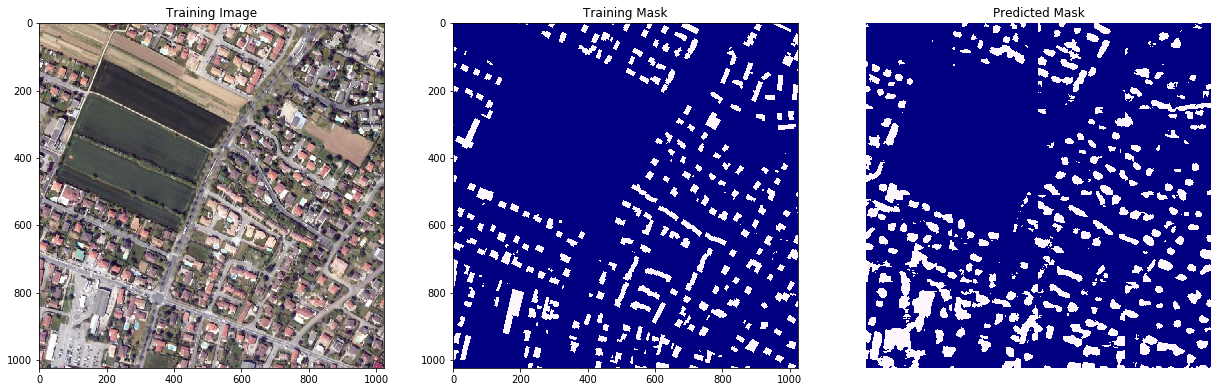

Lyon_0_0


In [41]:
model = get_unet_6()
model.load_weights('1_unet6_c1.hdf5')
img_id = Image_ID[0]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


True


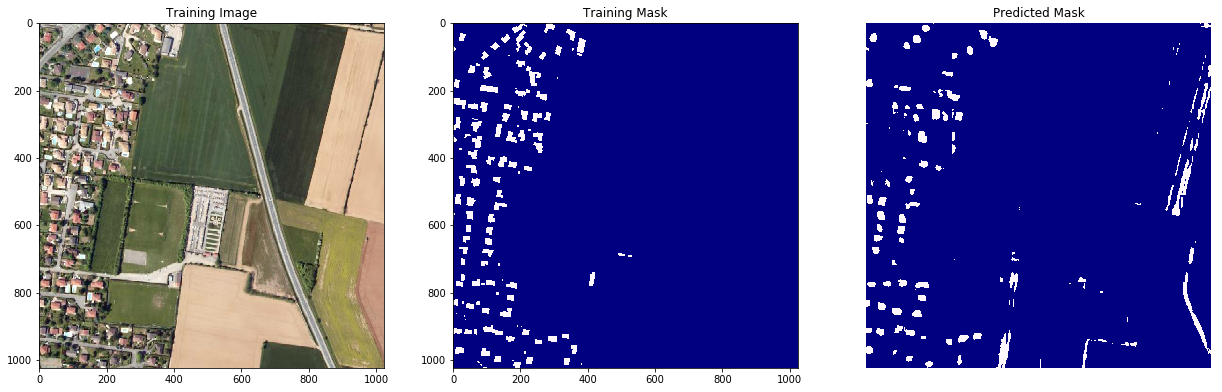

In [40]:
img_id = Image_ID[6]

check_predict(model, 0.5, img_id=img_id, Class_Type=1)


(1024, 1024, 3)


True


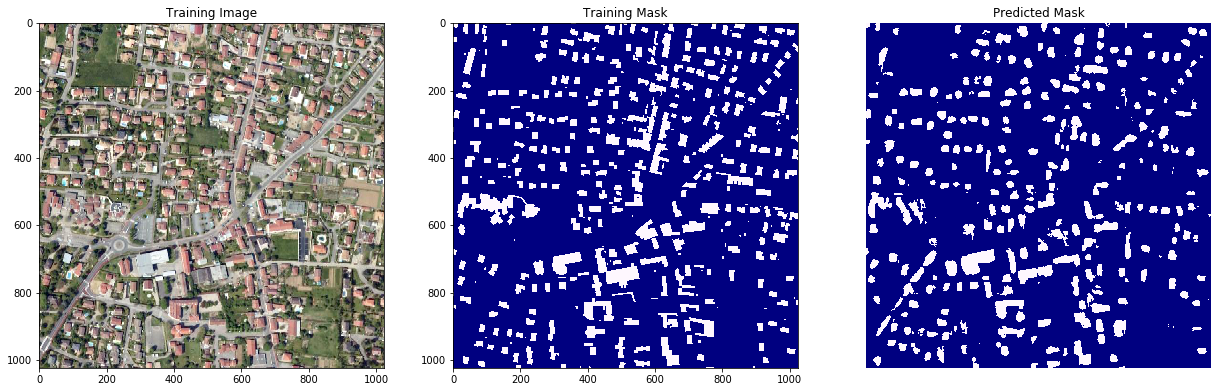

In [44]:
img_id = Image_ID[5]

check_predict(model, 0.5, img_id=img_id, Class_Type=1)


(1024, 1024, 3)


True


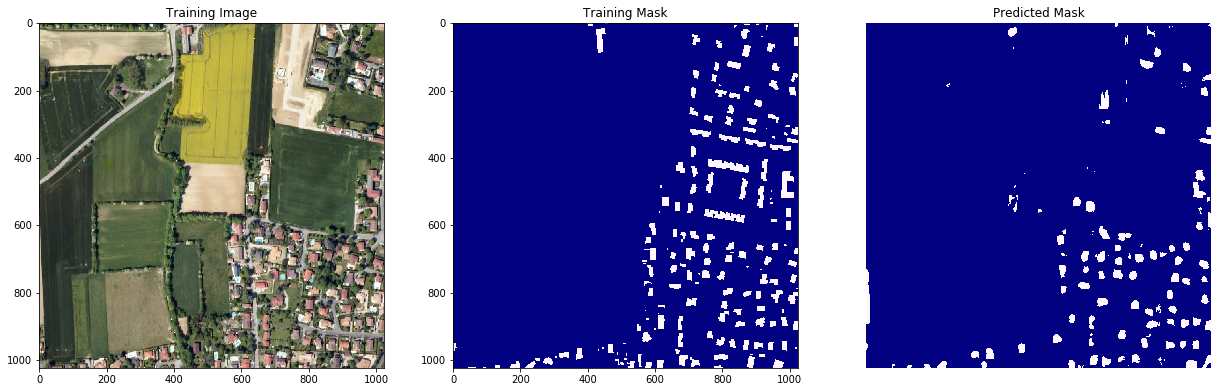

In [45]:
img_id = Image_ID[4]

check_predict(model, 0.5, img_id=img_id, Class_Type=1)


(1024, 1024, 3)


True


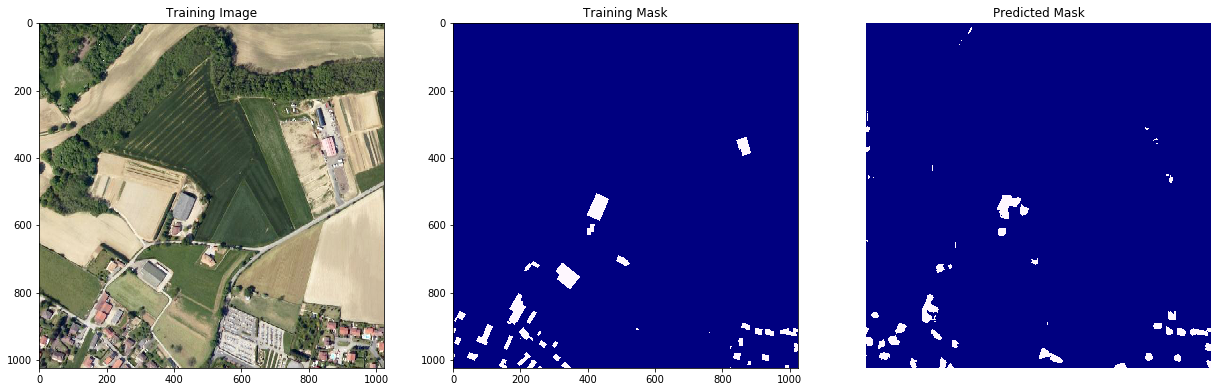

In [47]:
img_id = Image_ID[3]

check_predict(model, 0.5, img_id=img_id, Class_Type=1)


(1024, 1024, 3)


True


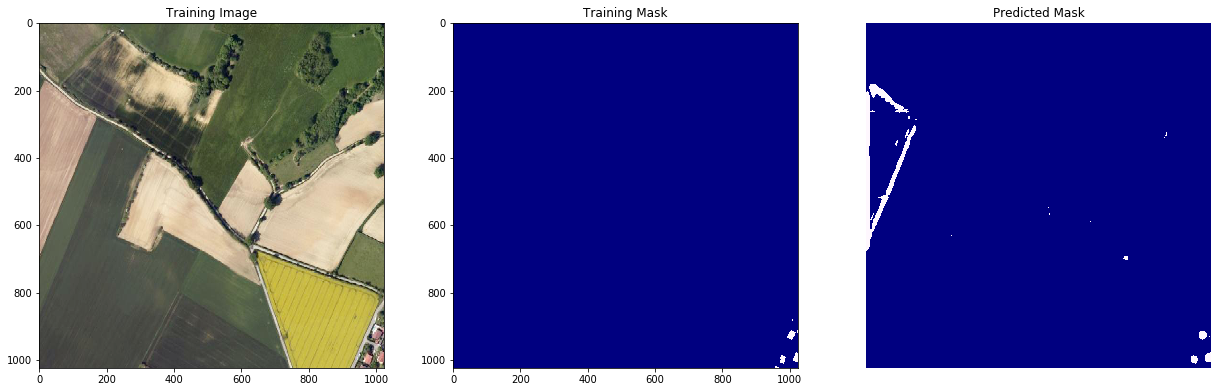

In [48]:
img_id = Image_ID[2]

check_predict(model, 0.5, img_id=img_id, Class_Type=1)

(1024, 1024, 3)


True


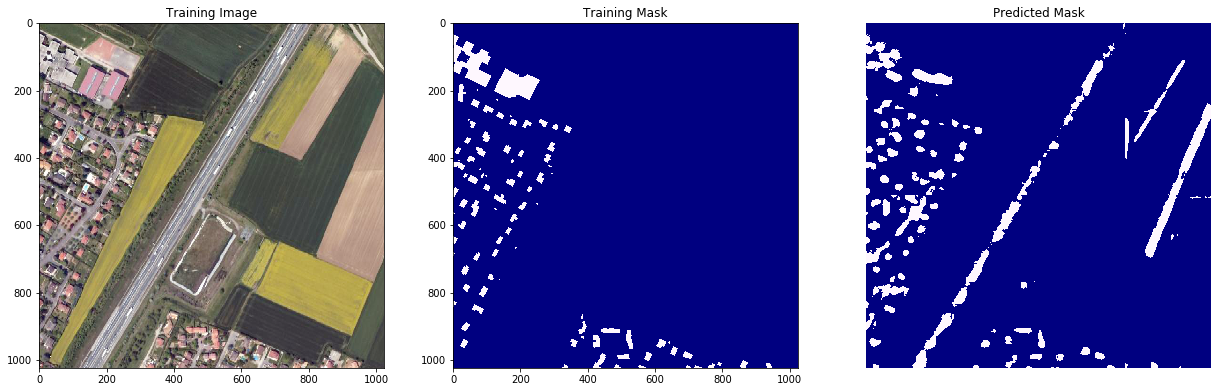

In [49]:
img_id = Image_ID[1]

check_predict(model, 0.5, img_id=img_id, Class_Type=1)


(1024, 1024, 3)


True


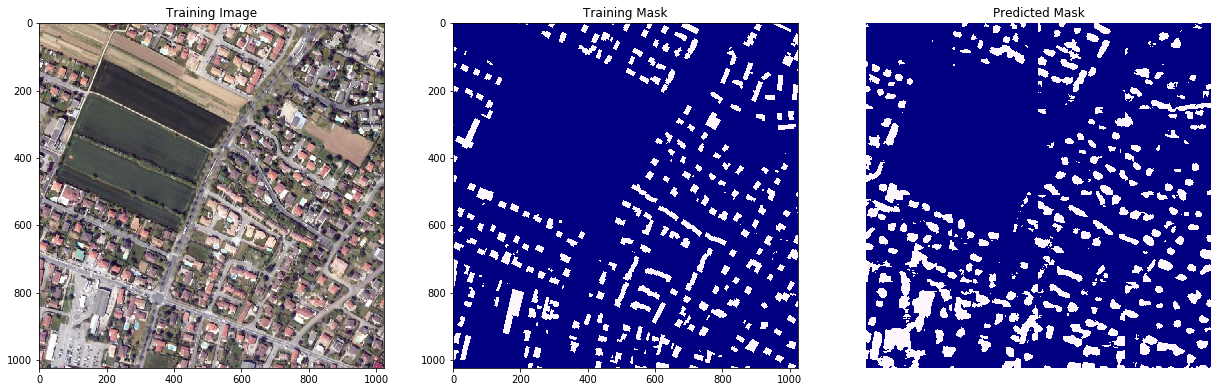

In [51]:
img_id = Image_ID[0]

check_predict(model, 0.5, img_id=img_id, Class_Type=1)
